# Project 1: Lane Finding

## Import Important Packages

In [336]:
#start by importing some packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


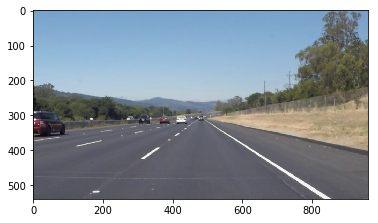

In [181]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image) # if you wanted to show a single color channel, call as plt.imshow(gray, cmap='gray')

## Pipeline for Image: Transform the Image and Add Lines

### Plan of Action:

* play around with grayscale, canny edge detection, gaussian blur, hough lines until image can be used to find lines
* use the draw lines function in helper functions to draw the lines
* overlay lines onto image for a 'weighted image'

### Execution:  

In [182]:
# First step, write the grayscale function
def grayscale(img): 
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

In [183]:
# Use the helper function grayscale to change image to B&W
gray = grayscale(image)

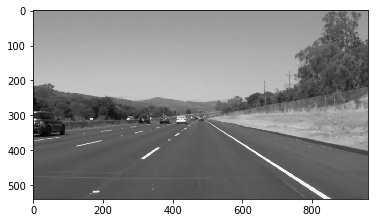

In [184]:
# Plot the gray array onto a graph to see the image
gray_plot = plt.imshow(gray, cmap='gray')

In [185]:
# Second step, write the Canny Edge Detection
def canny(img, low_threshold, high_threshold):
    return cv2.Canny(img, low_threshold, high_threshold)

In [200]:
# Use to the helper function to find the edges in the image, or areas of high differential
# Since the lanes present an area where the edges are REALLY sharp, I decided to use a high low-threshold to get rid of the noise in the image
canny_image = canny(gray, 200, 300)

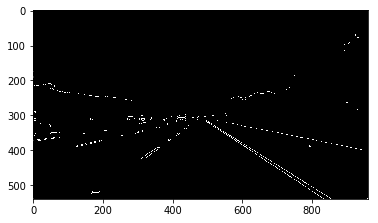

In [187]:
canny_plot = plt.imshow(canny_image, cmap='gray')

In [188]:
# Write a Gaussian Blur helper function to smooth the image
def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

In [308]:
# Use the helper function to make the edges more clear in areas where the differential is high
gaussian_image = gaussian_blur(canny_image, 5)

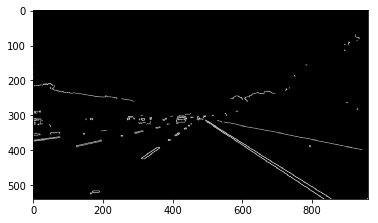

In [309]:
gaussian_plot = plt.imshow(gaussian_image, cmap='gray')

I was debating whether for this assignment we should include other lanes. For simplification, we're going to assume the car has to stay in its lane. The lane should be within a certain parameter of the camera infront of the car and ignore other lanes.

In [191]:
# Define a region of interest mask.
def region_of_interest(img, vertices):
    #defining a blank mask to start with
    mask = np.zeros_like(img)
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]
        ignore_mask_color = (255,) * channel_count
    else: 
        ignore_mask_color = 255
    
    #filling pixels inside the polygon defined by "vertices" with the fill color
    cv2.fillConvexPoly(mask, np.array(vertices, 'int32'), 255)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    
    return masked_image

In [192]:
roi_image = region_of_interest(gaussian_image, [(50, 550), (500, 300), (500, 300), (900, 550)])

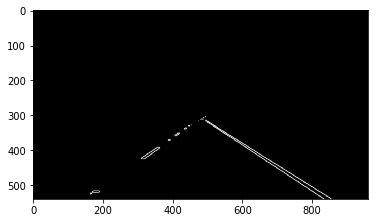

In [193]:
roi_plot = plt.imshow(roi_image, cmap='gray')

In [509]:
# Let's draw some lines!
def draw_lines(img, lines, color=[255, 0, 0], thickness=15):
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = abs(y2 - y1)/abs(x2 - x1)
            if 0.46 < slope < 0.465 or 0.60 < slope < 0.65:
                cv2.line(img, (x1, y1), (x2, y2), color, thickness)

In [510]:
# Now that we've defined the area of interest for the image and how to draw the lines, let's draw Hough Lines to connect lane segments
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_len, max_line_gap):
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    for line in lines:
        slope = str(abs(line[0][3] - line[0][1])/abs(line[0][2] - line[0][0]))
#         print("slope: " + slope)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

Because the video that is generated looks something like where there's a problem with lines that aren't lanes be connected by segments (left side lane to right side, and right side lane to left side, we are going to limit the segments by filtering out a certain slope that we're looking for.

We're going to write a new draw_lines function that filters out most line segments based on their slops, with exception of the lane lines at the forefront of the camera. This will be used in the video processing. 

In [534]:
hough_image = hough_lines(roi_image, 1, 1, 30, 0, 0, 100)

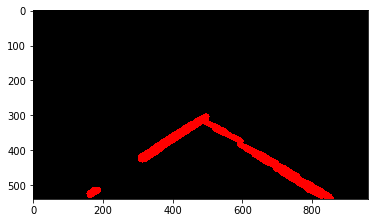

In [535]:
hough_plot = plt.imshow(hough_image, cmap='gray')

### We drew approximating lines!

### Next, we add the lines onto the original image

In [536]:
# We call this the weighted image, for having the lines on top of the original image
def weighted_img(img, initial_img, a=0.8, b=1, c=0.):
    return cv2.addWeighted(initial_img, a, img, b, c)

In [537]:
weighted = plt.imshow(weighted_img(hough_image, image))

TypeError: Expected Ptr<cv::UMat> for argument 'src1'

### Nice! We just completed drawing lanes lines onto an image.

## Image Pipeline: 

In [538]:
def image_pipeline(image_site): 
    image = mpimg.imread('test_images/{}'.format(image_site))
    gray = grayscale(image)
    canny_image = canny(gray, 200, 300)
    gaussian_image = gaussian_blur(canny_image, 5)
    roi_image = region_of_interest(gaussian_image, [(50, 550), (500, 300), (500, 300), (900, 550)])
    hough_image = hough_lines(roi_image, 1, 1, 30, 0, 0, 150)
    weighted = plt.imshow(weighted_img(hough_image, image))
    return weighted

In [539]:
import os 
test_images = os.listdir("test_images/")

solidYellowCurve.jpg
solidYellowLeft.jpg
solidYellowCurve2.jpg
solidWhiteRight.jpg
whiteCarLaneSwitch.jpg
solidWhiteCurve.jpg


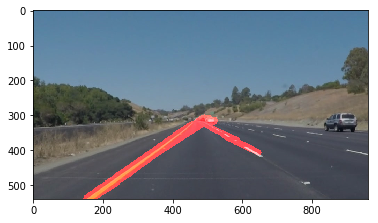

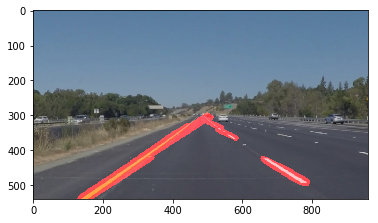

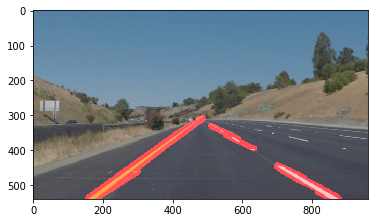

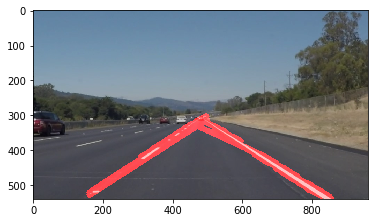

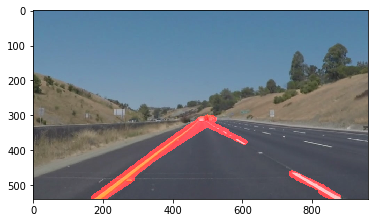

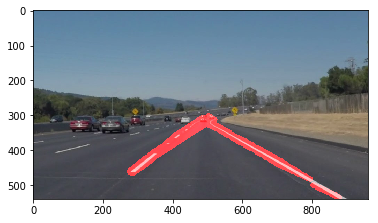

In [540]:
# Put test_images through the pipeline
n = 0
for image in test_images:
    figure = plt.figure()
    axes = figure.add_subplot(111)   
    print(image)
    converted_image = image_pipeline(image)
    figure.savefig('test_{}.png'.format(n))
    n = n+1


## Video Pipeline

In [541]:
from moviepy.editor import VideoFileClip
from IPython.display import display, HTML

In [548]:
def process_image(image): 

    gray = grayscale(image)
    canny_image = canny(gray, 200, 300)
    gaussian_image = gaussian_blur(canny_image, 5)
    roi_image = region_of_interest(gaussian_image, [(50, 550), (500, 300), (500, 300), (900, 550)])
    hough_image = hough_lines(roi_image, 1, 1, 30, 0, 0, 150)
    weighted = weighted_img(hough_image, image)
    
    return weighted

In [553]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(white_output, audio=False)

t:   4%|▎         | 8/221 [00:00<00:02, 74.83it/s, now=None]

Moviepy - Building video test_videos_output/solidWhiteRight.mp4.
Moviepy - Writing video test_videos_output/solidWhiteRight.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/solidWhiteRight.mp4
CPU times: user 2.48 s, sys: 293 ms, total: 2.77 s
Wall time: 7.78 s


In [554]:
%%HTML
<video width=400 controls>
  <source src="test_videos_output/solidWhiteRight.mp4" type="video/mp4">
</video>

After playing around with mainly several Hough Max Line Gaps values and slope values, I found that the flickering line that appears on the right side of this video is quite difficult to get rid of. My hypothesis is that it's hard to get rid of the flicker b/c that Hough Max Line Gap value and slope value coincides with the slope values of other lines that make up the right side and that are important to the makeup of the right side. 

The above video is the one I'm submitting for the assignment and I'm moving on to the yellow lane lines.

In [555]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

t:   1%|          | 7/681 [00:00<00:09, 68.67it/s, now=None]

Moviepy - Building video test_videos_output/solidYellowLeft.mp4.
Moviepy - Writing video test_videos_output/solidYellowLeft.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/solidYellowLeft.mp4
CPU times: user 7.66 s, sys: 897 ms, total: 8.56 s
Wall time: 27.4 s


In [558]:
HTML("""
<video width="400" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

This is okay, there are still some lane segments, but I'm not sure why this is more difficult considering I do change the images in the video to grayscale and it is able to detect the yellow lane lines. 

## Challenge Video Submission!

In [559]:
challenge_output = 'test_videos_output/challenge.mp4'
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

t:   2%|▏         | 4/251 [00:00<00:06, 38.70it/s, now=None]

Moviepy - Building video test_videos_output/challenge.mp4.
Moviepy - Writing video test_videos_output/challenge.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/challenge.mp4
CPU times: user 6.65 s, sys: 1.11 s, total: 7.76 s
Wall time: 20 s


In [926]:
HTML("""
<video width="400" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

For this video, I'm going to up the Gaussian Blur, change the slope of the right and left side, and check the mask, which should limit where the lanes can be. I might also try putting a Canny Edge Filter on top of the Gaussian Blur, maybe even multiple times. 

In [697]:
# Let's draw some robust lines!
def challenge_draw_lines(img, lines, color=[255, 0, 0], thickness=15):
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = abs(y2 - y1)/abs(x2 - x1)
            if 0.46 < slope < 0.465 or 0.63 < slope < 0.65:
                cv2.line(img, (x1, y1), (x2, y2), color, thickness)

In [698]:
# Now that we've defined the area of interest for the image and how to draw the lines, let's draw some robust Hough Lines to connect lane segments
def challenge_hough_lines(img, rho, theta, threshold, min_line_len, max_line_len, max_line_gap):
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    for line in lines:
        slope = str(abs(line[0][3] - line[0][1])/abs(line[0][2] - line[0][0]))
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    challenge_draw_lines(line_img, lines)
    return line_img

In [699]:
def challenge_process_image(image): 

    gray = grayscale(image)
    
    canny_image = canny(gray, 200, 300)
    gaussian_image = gaussian_blur(canny_image, 5)
    canny_image_2 = canny(gaussian_image, 200, 300)
#    gaussian_image_2 = gaussian_blur(canny_image_2, 51)
    
    roi_image = region_of_interest(canny_image_2, [(50, 550), (500, 350), (500, 350), (900, 550)])
    challenge_hough_image = hough_lines(roi_image, 1, 1, 30, 0, 0, 150)
    weighted = weighted_img(challenge_hough_image, image)
    
    return weighted

In [700]:
challenge_output = 'test_videos_output/challenge.mp4'
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(challenge_process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

t:   2%|▏         | 5/251 [00:00<00:05, 45.79it/s, now=None]

Moviepy - Building video test_videos_output/challenge.mp4.
Moviepy - Writing video test_videos_output/challenge.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/challenge.mp4
CPU times: user 6.2 s, sys: 1.13 s, total: 7.33 s
Wall time: 23.4 s


In [701]:
HTML("""
<video width="400" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

From this process, I found that there are two main problem areas:
* whenever a tree or shadows come up, the canny edge detection detects the tree and draws lines to the tree
* the yellow line is hard to see in the sun
* the right lane is MISSING!

I'd like to try to rectify these situations by taking image capture of the specific problem areas and working on those specific images. 

From the original challenge video, I'm going to take screenshots of the three problem areas and save it in a challenge_images folder. 

In [702]:
%%HTML
<video width=400 controls>
  <source src="test_videos/challenge.mp4" type="video/mp4">
</video>

Done! Now I'm going to load those five images and experiment with having extra Canny Edge Detection and Gaussian Blurring. 

In [703]:
import os 
challenge_images = os.listdir("challenge_images/")

In [704]:
def challenge_process_image(image): 

    gray = grayscale(image)
    
    canny_image = canny(gray, 200, 300)
    gaussian_image = gaussian_blur(canny_image, 5)
    canny_image_2 = canny(gaussian_image, 200, 300)
#   gaussian_image_2 = gaussian_blur(canny_image_2, 51)
    
    roi_image = region_of_interest(canny_image_2, [(50, 550), (500, 350), (500, 350), (900, 550)])
    challenge_hough_image = hough_lines(roi_image, 1, 1, 30, 0, 0, 150)
    weighted = weighted_img(challenge_hough_image, image)
    
    return weighted

That was actually difficult, so I'm going to load up the images one by one and process them. Looking back, my ROI was way off since the images I used are screenshots and have many more times pixels. 

### Challenge: Driving by Trees with Shadows

In [705]:
challenge_tree_0 = mpimg.imread('challenge_images/challenge_tree_0.jpg')

AxesSubplot(0.125,0.125;0.775x0.755)


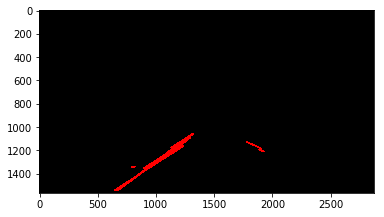

In [781]:
figure = plt.figure()
axes = figure.add_subplot(111)   
plt.imshow(challenge_tree_0)

# Playing around with different processes for challenge_tree_0

gray = grayscale(challenge_tree_0)
plt.imshow(gray, cmap="gray")

canny_image = canny(gray, 0, 300)
plt.imshow(canny_image, cmap="gray")

# TODO: Find way to get the plot axes, then use ratio/fractions to describe the region of interest (getting the image size is much easier)
axes = plt.axes()
print(axes)

# Since I'm having difficulty returning the plot axis size, I'm just going to define it according to estimation based on plot

# I'm going to do the region of interest first, before the gaussian blur
roi_image = region_of_interest(canny_image, [(500, 1600), (1200, 1000), (1800, 1000), (2500, 1600)])

# Gaussian Blur // the greater the gaussian blur, the clearer the line, not counting line lane segments
gaussian_image = gaussian_blur(roi_image, 7)

# Try Canny Edge Detection on the Gaussian Image
# Recall the variables for Canny are: img, low_threshold, high_threshold
canny_image_one = canny(gaussian_image, 0, 10)
# plt.imshow(canny_image_one, cmap="gray")

# Challenge Hough Transform (with challenge draw lines)
# Recall that the variables in hough_lines are: img, rho, theta, threshold, min_line_len, max_line_len, max_line_gap):

hough_image = challenge_hough_lines(canny_image_one, 2, 1, 30, 0, 0, 150)
plt.imshow(hough_image, cmap="gray")

converted_image = challenge_process_image(challenge_tree_0)
figure.savefig('challenge_tree_0')

After adjusting the ROI and running a second Canny Edge Detection on a higher Gaussian Blur, we have a much nicer looking line. This process separates the softer edges (such as the tree and its shadows) from the harder edges and within a cleaner ROI. Now I'm going to try this pipeline on image challenge_tree_1.png.

In [748]:
challenge_tree_1 = mpimg.imread('challenge_images/challenge_tree_1.jpg')
#NOTE: png files do not work with opencv, only jpg

AxesSubplot(0.125,0.125;0.775x0.755)


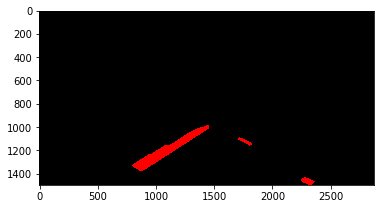

In [878]:
figure = plt.figure()
axes = figure.add_subplot(111)   
plt.imshow(challenge_tree_1)

# Playing around with different processes for challenge_tree_0

gray = grayscale(challenge_tree_1)
plt.imshow(gray, cmap="gray")

canny_image = canny(gray, 0, 300)
plt.imshow(canny_image, cmap="gray")

# TODO: Find way to get the plot axes, then use ratio/fractions to describe the region of interest (getting the image size is much easier)
axes = plt.axes()
print(axes)

# Since I'm having difficulty returning the plot axis size, I'm just going to define it according to estimation based on plot

# I'm going to do the region of interest first, before the gaussian blur
roi_image = region_of_interest(canny_image, [(500, 1600), (1200, 1000), (1800, 1000), (2500, 1600)])
plt.imshow(roi_image, cmap="gray")

# Gaussian Blur // the greater the gaussian blur, the clearer the line, not counting line lane segments
gaussian_image = gaussian_blur(roi_image, 21)
plt.imshow(gaussian_image, cmap="gray")

# Try Canny Edge Detection on the Gaussian Image
# Recall the variables for Canny are: img, low_threshold, high_threshold
canny_image_one = canny(gaussian_image, 0, 10)
plt.imshow(canny_image_one, cmap="gray")

# Challenge Hough Transform (with challenge draw lines)
# Recall that the variables in hough_lines are: img, rho, theta, threshold, min_line_len, max_line_len, max_line_gap):

hough_image = challenge_hough_lines(canny_image_one, 2, 1, 30, 0, 0, 200)
plt.imshow(hough_image, cmap="gray")

# converted_image = challenge_process_image(challenge_tree_1)
figure.savefig('challenge_tree_1.jpg')

hough_image_1 = grayscale(hough_image)
plt.imshow(hough_image_1, cmap="gray")

hough_image_1 = challenge_hough_lines(hough_image_1, 5, 1, 5, 5, 1000, 1000)
plt.imshow(hough_image_1)

This (challenge_tree_1.jpg) is looking pretty good. I changed the rho in the Hough Transform to 2, which brought back the segments on the right side of the lane. Because I know that the Hough Transform connects dots, I'm going to do a second Hough Transform that'll bring the segments together. 

In [816]:
challenge_tree_1_hough_1 = mpimg.imread('challenge_tree_1.jpg')

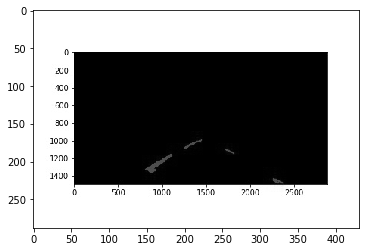

In [852]:
# Challenge Hough Transform (with challenge draw lines)
# Recall that the variables in hough_lines are: img, rho, theta, threshold, min_line_len, max_line_len, max_line_gap):
# NOTE/TODO: Figure out a way to find the best/optimize parameters for each function
# NOTE: Hough Transform only takes grayscale images

gray_hough_image = grayscale(challenge_tree_1_hough_1)
plt.imshow(gray_hough_image, cmap="gray")
hough_image_1 = challenge_hough_lines(gray_hough_image, 1, 1, 0, 0, 20, 100)

# plt.imshow(hough_image_1, cmap="gray")

This is importing the plot instead of just the image and is messing up my Hough Transform, so I'm just going to do it in the previous cells. 

The second Hough Transform worked pretty well for the left side, but not very good for connecting the lane segments on the right side. There will also be the problem of having one pipeline for multiple, different looking images. This makes me think that instead of using traditional computer vision to try to guess where the lanes are, there should be a special paint that is used for automonous vehicles that helps the computer 'see'. But moving forward, I'm going to try to correct for the yellow lanes. 

### Challenge: Driving by roads with low contrast for lanes due to environmental factors (such as bright sunlight)

In [898]:
challenge_low_contrast_0 = mpimg.imread('challenge_images/challenge_low_contrast_0.jpg')

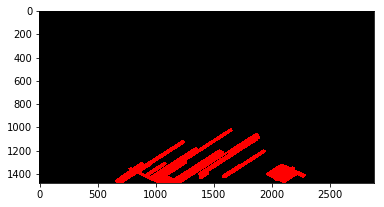

In [914]:
figure = plt.figure()
axes = figure.add_subplot(111)   
plt.imshow(challenge_low_contrast_0)

gray = grayscale(challenge_low_contrast_0)
plt.imshow(gray, cmap="gray")

canny_image = canny(gray, 0, 75)
plt.imshow(canny_image, cmap="gray")

# I'm going to do the region of interest first, before the gaussian blur
roi_image = region_of_interest(canny_image, [(500, 1600), (1200, 1000), (1800, 1000), (2500, 1600)])
plt.imshow(roi_image, cmap="gray")

# Gaussian Blur // the greater the gaussian blur, the clearer the line, not counting line lane segments
gaussian_image = gaussian_blur(roi_image, 21)
plt.imshow(gaussian_image, cmap="gray")

# Try Canny Edge Detection on the Gaussian Image
# Recall the variables for Canny are: img, low_threshold, high_threshold
canny_image_one = canny(gaussian_image, 0, 10)
plt.imshow(canny_image_one, cmap="gray")

# Challenge Hough Transform (with challenge draw lines)
# Recall that the variables in hough_lines are: img, rho, theta, threshold, min_line_len, max_line_len, max_line_gap):

hough_image = challenge_hough_lines(canny_image_one, 2, 1, 30, 0, 0, 200)
plt.imshow(hough_image, cmap="gray")

# converted_image = challenge_process_image(challenge_tree_1)
figure.savefig('challenge_low_contrast_0_try.jpg')

hough_image_1 = grayscale(hough_image)
plt.imshow(hough_image_1, cmap="gray")

hough_image_1 = challenge_hough_lines(hough_image_1, 5, 1, 5, 5, 1000, 1000)
plt.imshow(hough_image_1)

After fiddling around with the parameters for the yellow lane lines (see challenge_low_contrast_0_try.jpg), I realized that the best way is to look for yellow lane lines instead of grayscaling the entire image. 

However, I am curious about what the video looks like with these new parameters, especially with the ROI function moved to earlier in the process and there being an extra Hough Transform. 

### Challenge: Video

In [947]:
def challenge_process_image_1(image): 

    gray = grayscale(image)
    
    canny_image = canny(gray, 0, 75)
    roi_image = region_of_interest(canny_image, [(50, 550), (500, 300), (500, 300), (900, 550)])
    gaussian_image = gaussian_blur(roi_image, 21)
    hough_image = challenge_hough_lines(canny_image_one, 2, 1, 30, 0, 0, 200)    
    roi_image = region_of_interest(canny_image_one, [(50, 550), (500, 350), (500, 350), (900, 550)])
    challenge_hough_image = hough_lines(roi_image, 1, 1, 30, 0, 0, 150)
    hough_image_1 = grayscale(challenge_hough_image)
    hough_image_1 = challenge_hough_lines(hough_image_1, 5, 1, 5, 5, 1000, 1000)

    weighted = weighted_img(hough_image_1, image)
    
    return weighted

In [948]:
challenge_output = 'test_videos_output/challenge.mp4'
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(challenge_process_image_1)
%time challenge_clip.write_videofile(challenge_output, audio=False)

  """



TypeError: 'NoneType' object is not iterable

In [944]:
%%HTML
<video width=400 controls>
  <source src="test_videos_output/challenge.mp4" type="video/mp4">
</video>

Due to time constraints, I'm going to put this aside. The video is not processing as I expected, and I'm not sure how to fix it. Will come back to this at a later time. 